# 1. Installs + Imports

In [ ]:
#!pip install sentence-transformers openai==0.28.1 datasets

In [2]:
from collections import defaultdict
import concurrent.futures
from functools import partial, lru_cache
import pandas as pd
import openai, os
from openai.embeddings_utils import get_embeddings, get_embedding
import json

from transformers import RobertaTokenizer
import random
from datasets import load_dataset
import itertools
import numpy as np
from torch.utils.data import DataLoader
import re
import string
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer, evaluation, losses, InputExample

import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split


random.seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Data loading and preprocessing

### 2.1. Let's download our first dataset

In [4]:
pre_merged_anime = pd.read_csv('drive/MyDrive/pre_merged_anime.csv').dropna()[:10000]
print(pre_merged_anime.shape)
pre_merged_anime.head(2)

(10000, 19)


,MAL_ID,Name,Score,Genres,English name,Type,Episodes,Premiered,Producers,Studios,Source,Duration,Rating,Ranked,Members,Favorites,Completed,On-Hold,synopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,26,Spring 1998,Bandai Visual,Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,1251960,61971,718161,71513,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,Movie,1,Unknown,"Sunrise, Bandai Visual",Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,273145,1174,208333,1935,"other day, another bounty—such is the life of ..."


### 2.2. Let's check does the text in 'synopsis' column have unprintable symbols.

In [5]:
unprintable_symbols=''
for i in pre_merged_anime['synopsis']:
    for j in i:
        if j not in string.printable:
            unprintable_symbols+=f'{j} '
unprintable_symbols

'— — — — — é — — — — — ’ — — — — — — — — — — — — ä — — — é — — — — — — — — — Ü Ü Ü — — — — — — é ō ō — — — — é ’ é ’ ’ — — — — — — — — ’ — — … — — — — — — — — — — — — — — — — — — — — ’ — ☆ ï — — — — — ½ — — — — — — — — — — — — — — — — — é é é é é é é ’ “ ” — — — — — — — — — — — — É è É è — — — — — — — — — — ☆ ’ — ’ — — — — — — — ’ — — — — — — — — — — — — — — — — — — ♥ — — — — — — é — — ± — — — — — — — — — — — — — — — — — — — — — “ ’ — — — — — — — — — — — — — ☆ ☆ — — — — — — — — — — — — ’ ’ — — é é ’ é é é ’ — — — — — ’ é — — — ä ä ä — — — — ’ – ’ “ ” — – ō ō ō — — — — — ’ ’ — — — ― ― — — — — — — — — — — — — — — — — — — — ’ ’ ’ ’ ’ … ’ ’ ’ ’ ’ — — — — — — — — — — — ’ — ’ ’ — — — ’ ’ ’ ’ ’ — — — — — — — é ï — — — — — — — — ’ ’ ’ — — — — — ’ ’ — — — — é — \u2060 — é — — — — — — — ’ — — — ’ ° — — — — — — — — — — — é é — é — é é é é é — é — — — … — — — — — — — — — — — ç è — — — — — — — — — — — … ’ — — — — — — — — — — — — — — — “ ” “ ” ’ ’ “ ” “ ” — … — — — — — — — — — — — — — — ’ è è － “ ” 

Let's write function which delete unprintable symbols.

In [6]:
def clean_text(text):
    text = ''.join(filter(lambda x: x in string.printable, text))
    text = re.sub(r'\s{2,}', ' ', text).strip()
    return text.strip()

### 2.3. We will use our own description for each anime. Let's write this function.

In [7]:
def get_anime_description(anime_row):
    anime_type = "TV Show" if anime_row["Type"] == "TV" else anime_row["Type"]
    description = (
        f"{anime_row['Name']} is a {anime_type}.\n"
        f"Synopsis: {anime_row['synopsis']}\n"
        f"It was produced by {anime_row['Producers']} and it is from {anime_row['Studios']} Studio.\n"
        f"Its source is {anime_row['Source']}.\n"
        f"It premiered in {anime_row['Premiered']}.\n"
        f"Its genres are {anime_row['Genres']}\n"
    )
    return clean_text(description)


### 2.4. Let's apply this function to our dataset.

In [8]:
pre_merged_anime['generated_description'] = pre_merged_anime.apply(get_anime_description, axis=1)


In [85]:
pre_merged_anime[['MAL_ID','generated_description']]

,MAL_ID,generated_description
0,1,Cowboy Bebop is a TV Show.\nSynopsis: In the y...
1,5,Cowboy Bebop: Tengoku no Tobira is a Movie.\nS...
2,6,Trigun is a TV Show.\nSynopsis: Vash the Stamp...
3,7,Witch Hunter Robin is a TV Show.\nSynopsis: ch...
4,8,Bouken Ou Beet is a TV Show.\nSynopsis: It is ...
...,...,...
9995,31698,Zhan Long Si Qu is a TV Show.\nSynopsis: Go fo...
9996,31699,Good Morning!!! Doronjo is a TV Show.\nSynopsi...
9997,31700,Xiao Taiji is a TV Show.\nSynopsis: No synopsi...
9998,31701,Wu Lan Qi Qi Ge is a TV Show.\nSynopsis: No sy...


In [9]:
unprintable_symbols=''
for i in pre_merged_anime['generated_description']:
    for j in i:
        if j not in string.printable:
            unprintable_symbols+=f'{j} '
unprintable_symbols

''

### 2.5. Let's downoad our second dataset

In [10]:
rating_complete = pd.read_csv('drive/MyDrive/rating_complete.csv').dropna()[:5000000]
rating_complete.shape


(1000000, 3)

### 2.6. For some (unknown to me) reason we add additional column 'nps_score' to this DataFrame

In [11]:
score_map = {10: 1, 9: 1, 8: 0, 7: 0, 6: -1, 5: -1, 4:-1, 3:-1, 2:-1, 1:-1, 0:-1}
rating_complete['nps_score'] = rating_complete['rating'].map(score_map)
rating_complete = rating_complete[rating_complete['nps_score'] != 0]
print(rating_complete.shape)
rating_complete.head(2)

(511369, 4)


,user_id,anime_id,rating,nps_score
0,0,430,9,1
1,0,1004,5,-1


### 2.7. Let's check the number of reviews for each anime and slice 0.9 quantile

<Axes: >

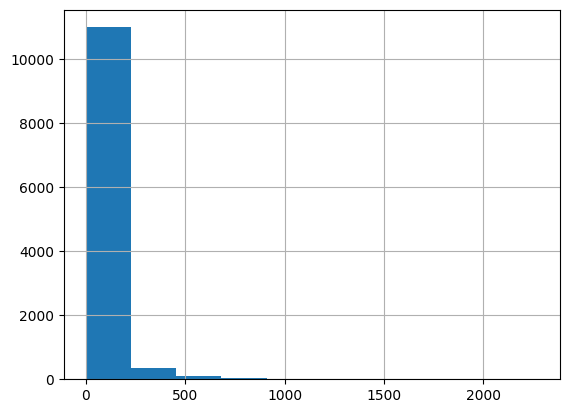

In [12]:
rating_complete.groupby('anime_id').count()['rating'].hist()

In [13]:
# remove all rows with animes with under median_reviews reviews
median_reviews = rating_complete.groupby('anime_id').count()['rating'].quantile(.90)
print(median_reviews)
animes_with_enough_reviews = rating_complete.groupby('anime_id').count()['rating'] >= median_reviews

rating_complete = rating_complete[rating_complete['anime_id'].isin(animes_with_enough_reviews[animes_with_enough_reviews].index)]

print(rating_complete.shape)
rating_complete.head(2)

107.0
(345481, 4)


,user_id,anime_id,rating,nps_score
0,0,430,9,1
1,0,1004,5,-1


<Axes: >

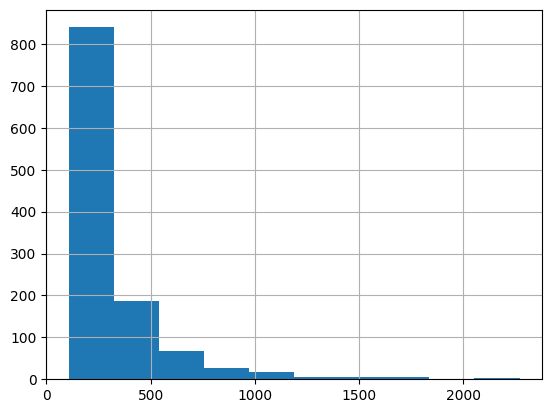

In [14]:
rating_complete.groupby('anime_id').count()['rating'].hist()

### 2.8. Here we split the second dataset

In [15]:
rating_complete_train, rating_complete_test = \
              np.split(rating_complete.sample(frac=1, random_state=42),
                       [int(.9*len(rating_complete))])

In [16]:
print(rating_complete_train.shape)
print(rating_complete_test.shape)

(310932, 4)
(34549, 4)


# 3. We want to embed the anime's description. But first we need fine-tune it. And before this we need dataset for fine-tuning.

The idea for fine-tuning is the next. We need some data for fine-tuning. What do we want to fine-tune? We want to fine-tune the embedder. So we will use sentence-transformers library. There are different structures for fine-tuning the models from the library. We will choose the stucture {sent1, sent2, score}.

So we will have the pairs of animes descriptions. What about the score? We must construct it. We can do the next thing. Let's explain the idea in the next steps:

1. If we take two animes we can find a user who rated them both. If he liked them both then this two animes are similiar. If user likes one and does not like other then they are not similiar.

2. Then let's find all users who rated this pair of animes. Count which part of them likes both animes. And this will be our score.

### 3.1. First we get the list of anime ids which are common to both datatsets.

In [17]:
anime_ids = sorted(set(pre_merged_anime['MAL_ID'].unique()) & set(rating_complete_train['anime_id'].unique()))

Note that in anime_ids there are not duplicates due to the definition of sets and set operations.

### 3.2. Then we create combinations

In [18]:
anime_pairs = set(itertools.combinations(anime_ids, 2))

We make them sets for better performance.

### 3.3. For some reasons we also implement the following functionality.

In [19]:
len(anime_pairs)

429201

In [20]:
SAMPLE = 1000  # only taking a sample of the pairs to scan
if SAMPLE:
    anime_pairs = random.sample(anime_pairs, SAMPLE)

<ipython-input-20-8dac9d0d454d>:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  anime_pairs = random.sample(anime_pairs, SAMPLE)


In [21]:
len(anime_pairs)

1000

### 3.4. Let's discuss some pandas features

If we want to look at rows for animes with ids 20 and 68 we can do the next.

In [22]:
for_example=rating_complete_train[rating_complete_train['anime_id'].isin([20, 68])]
for_example

,user_id,anime_id,rating,nps_score
505452,3284,68,10,1
632259,4129,20,4,-1
436565,2809,68,10,1
455773,2940,20,9,1
458217,2954,20,9,1
...,...,...,...,...
248830,1527,20,5,-1
620181,4028,20,6,-1
398220,2515,20,9,1
304267,1898,20,9,1


Do we need user how rated only one anime? I do not understand the logic behind this but we say No.

In [23]:
for_example = for_example[for_example.duplicated(subset=['user_id'], keep=False)].sort_values('user_id')
for_example

,user_id,anime_id,rating,nps_score
10408,78,68,9,1
10444,78,20,10,1
19725,153,20,10,1
19531,153,68,10,1
20043,154,68,6,-1
...,...,...,...,...
971347,6246,68,9,1
982570,6313,68,9,1
982747,6313,20,9,1
987885,6357,20,6,-1


This line of code is doing two main things:

1. a.duplicated(subset=['user_id'], keep=False): This part of the code is creating a boolean mask for the DataFrame a. It checks if the 'user_id' is duplicated in the DataFrame. The keep=False argument means that it will mark all duplicates as True, not just the second and subsequent occurrences. So, if a 'user_id' appears more than once in the DataFrame, all its occurrences will be marked as True.
2. [...]: This part of the code is using the boolean mask to filter the DataFrame a. Only the rows where the mask is True (i.e., the 'user_id' is duplicated) will be kept.
3. .sort_values('user_id'): Finally, this part of the code sorts the filtered DataFrame based on the 'user_id' column.

In [24]:
for_example=for_example.groupby('user_id', group_keys=True)['nps_score'].apply(sorted)
for_example

user_id
78        [1, 1]
153       [1, 1]
154      [-1, 1]
375      [-1, 1]
433      [-1, 1]
439     [-1, -1]
440       [1, 1]
446      [-1, 1]
689       [1, 1]
719      [-1, 1]
851     [-1, -1]
1094     [-1, 1]
1752      [1, 1]
1916     [-1, 1]
2403    [-1, -1]
2450     [-1, 1]
2809      [1, 1]
2866      [1, 1]
2919    [-1, -1]
3260    [-1, -1]
3354      [1, 1]
3399      [1, 1]
3558    [-1, -1]
3578      [1, 1]
3651      [1, 1]
3663     [-1, 1]
3836     [-1, 1]
3842     [-1, 1]
3899      [1, 1]
3916    [-1, -1]
4036    [-1, -1]
4136      [1, 1]
4396      [1, 1]
4732     [-1, 1]
5009     [-1, 1]
5043     [-1, 1]
5117      [1, 1]
5211    [-1, -1]
5558     [-1, 1]
5778      [1, 1]
5910     [-1, 1]
5947    [-1, -1]
6084    [-1, -1]
6095     [-1, 1]
6246      [1, 1]
6313      [1, 1]
6357    [-1, -1]
Name: nps_score, dtype: object

In [25]:
for_example=for_example[for_example.isin([[-1, 1], [1, 1]])].value_counts(normalize=True)
for_example

[1, 1]     0.514286
[-1, 1]    0.485714
Name: nps_score, dtype: float64

In [26]:
for_example.sort_index().tolist()

[0.4857142857142857, 0.5142857142857142]

In [27]:
def anime_pair_scores(a1, a2):
    a = rating_complete_train[rating_complete_train['anime_id'].isin([a1, a2])]

    # only keep rows with duplicates in the user_id column
    a = a[a.duplicated(subset=['user_id'], keep=False)].sort_values('user_id')
    # print(a.groupby('user_id')['nps_score'].apply(sorted).value_counts())

    anime_pair_scores = a.groupby('user_id', group_keys=True)['nps_score'].apply(sorted)

    two_scores = anime_pair_scores[anime_pair_scores.isin([[-1, 1], [1, 1]])].value_counts(normalize=True)
    if len(two_scores) != 2:
        return None
    disagree_score, positively_agree_score = two_scores.sort_index().tolist()  # [-1, 1], [1, 1]
    # return disagree_score, positively_agree_score

    if positively_agree_score > disagree_score:
        # print(f'{a1} and {a2} are similar')
        return positively_agree_score
    else:
        # print(f'{a1} and {a2} are dissimilar')
        return -1 * disagree_score

In [28]:
set_of_anime_pairs = set(anime_pairs)

In [29]:
'''
This script prepares training examples where each example consists of a pair of animes.
'''
# Initializing empty lists for storing positive and negative pairs examples
positive_pairs_examples, negative_pairs_examples = [], []
considered_pairs = {}
all_scores = []

unique_mal_ids = set(pre_merged_anime['MAL_ID'].unique())

# Setting the seed value for random function to ensure the reproducibility of results
random.seed(42)

# Looping over each pair of animes
for a1, a2 in tqdm(anime_pairs):
    # If any of the animes in the pair is not found in the pre_merged_anime dataframe index, we skip the current iteration
    if a1 not in unique_mal_ids or a2 not in unique_mal_ids:
        continue

    # Calculating similarity between the sets of users who like anime a1 and anime a2
    j = anime_pair_scores(a1, a2)
    all_scores.append(j)
    text_pair = pre_merged_anime[pre_merged_anime['MAL_ID'].isin([a1, a2])]['generated_description'].tolist()

    # If the similarity is non-zero (i.e., there are some common users)
    if j is not None:
        # If similarity is greater than or equal to 0.8,
        # then the pair is considered as a positive example and added to the positive_pairs_examples list
        if j >= 0.7:
            positive_pairs_examples.append(InputExample(texts=text_pair, label=j))

        # If similarity is less than -0.8,
        # then the pair is considered as a negative example and added to the negative_pairs_examples list
        elif j < -0.7:
            negative_pairs_examples.append(InputExample(texts=text_pair, label=j))


  0%|          | 0/1000 [00:00<?, ?it/s]

(count    885.000000
 mean       0.176305
 std        0.672927
 min       -0.954545
 25%       -0.578947
 50%        0.597015
 75%        0.743590
 max        0.964286
 dtype: float64,
 <Axes: >)

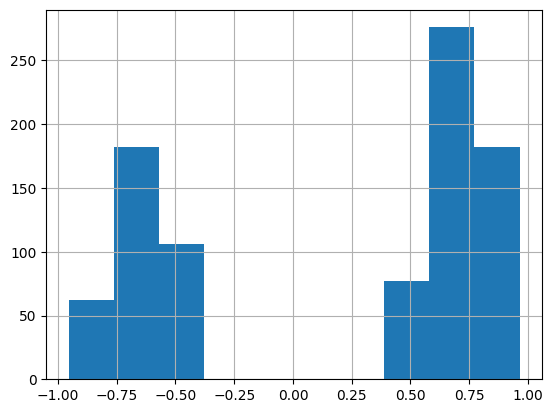

In [30]:
# Unsurprisingly, we get a multi-modal distribution where people tend to either agree or disagree considering we removed all nps scores of 0 :)
pd.Series(all_scores).describe(), pd.Series(all_scores).hist()

In [31]:
# This might seem like not a lot of data, but we will see sometimes that's all it takes!
len(positive_pairs_examples), len(negative_pairs_examples)

(270, 100)

In [32]:
positive_pairs_examples[0].__dict__  # example of a positive pair

{'guid': '',
 'texts': ['Highschool of the Dead is a TV Show.\nSynopsis: It happened suddenly: The dead began to rise and Japan was thrown into total chaos. As these monsters begin terrorizing a high school, Takashi Kimuro is forced to kill his best friend when he gets bitten and joins the ranks of the walking dead. Vowing to protect Rei Miyamoto, the girlfriend of the man he just executed, they narrowly escape their death trap of a school, only to be greeted with a society that has already fallen. Soon, Takashi and Rei band together with other students on a journey to find their family members and uncover what caused this overwhelming pandemic. Joining them is Saeko Busujima, the beautiful president of the Kendo Club; Kouta Hirano, an otaku with a fetish for firearms; Saya Takagi, the daughter of an influential politician; and Shizuka Marikawa, their hot school nurse. But will the combined strength of these individuals be enough to conquer this undead apocalypse?\nIt was produced by G

In [33]:
negative_pairs_examples[0].__dict__  # example of a negative pair

{'guid': '',
 'texts': ["Goshuushou-sama Ninomiya-kun is a TV Show.\nSynopsis: Shungo Ninomiya is just an ordinary, run-of-the-mill high school student who lives at home with his older sister Ryokoat least when she's not away doing her job as a mercenary. However, Shungo's life ceases to be normal the moment a cute girl named Mayu Tsukimura descends into the middle of his school's campus in a military-grade helicopter. It turns out Ryoko sent this girl, along with her older brother Mikihiro, to live at the Ninomiya household. But the newly-arrived siblings are a little special: Mayu is, in fact, a succubus and her brother, an incubus! And as if the circumstances are not problematic enough, Mayu is crippled with androphobiathe fear of menand it's up to Shungo to help her overcome this at the behest of his sister. Ryoko plans to force Mayu to be closer to Shungo, and to do this, shell employ some questionable methods such as having them share the same bed and even take baths together. Th

In [34]:
# Splitting them up separately to keep the split a bit stratefied.
train_positive_pairs, val_positive_pairs = train_test_split(positive_pairs_examples, test_size=0.2, random_state=42)
train_negative_pairs, val_negative_pairs = train_test_split(negative_pairs_examples, test_size=0.2, random_state=42)

# Combine positive and negative pairs
train_examples = train_positive_pairs + train_negative_pairs

# Combine positive and negative pairs for the validation set
val_examples = val_positive_pairs + val_negative_pairs

**Our dataset for training embedders is ready!!!**

# 4. Let's fine-tune our embedders.

### 4.1. Let's download our first embedder and look at its architecture.

In [35]:
anime_encoder = SentenceTransformer('paraphrase-distilroberta-base-v1')
anime_encoder

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

We see that the seq_length is only 128. Are we sure that it is enough for our inputs (descriptions)? Let's check it.

Token indices sequence length is longer than the specified maximum sequence length for this model (689 > 512). Running this sequence through the model will result in indexing errors


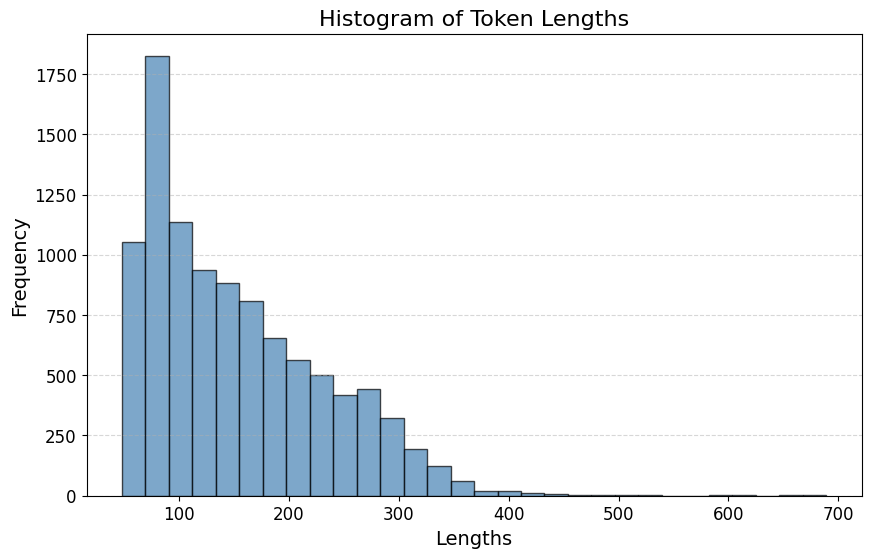

In [36]:
lengths = []
for c in pre_merged_anime['generated_description']:
    lengths.append(anime_encoder.tokenizer(c, return_tensors='pt')['input_ids'].shape[1])

# Set up the plot and histogram
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=30, edgecolor='black', color='steelblue', alpha=0.7)

# Customize the plot's appearance
plt.title("Histogram of Token Lengths", fontsize=16)
plt.xlabel("Lengths", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')

# Display the histogram
plt.show()

128 is very low for our inputs. So we will increase its value.

In [37]:
anime_encoder.max_seq_length = 384
anime_encoder

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

### 4.2. Now let's create val DataLoader.

In [38]:
# Create a DataLoader for the validation examples
val_dataloader = DataLoader(
    val_examples,
    batch_size=2,
    shuffle=True
)

# Extract sentences and scores from the validation examples
val_sentences1 = [ex.texts[0] for ex in val_examples]
val_sentences2 = [ex.texts[1] for ex in val_examples]
val_scores = [ex.label for ex in val_examples]

# Create the evaluator
evaluator = evaluation.EmbeddingSimilarityEvaluator(val_sentences1, val_sentences2, val_scores)

### 4.3. Let's check the performance of unfine-tuned models with 128 and 384 max_seq_length

In [39]:
# original architecture cuts off so much context becasue limit is 128
SentenceTransformer('paraphrase-distilroberta-base-v1').evaluate(evaluator)

0.20356269201777127

In [40]:
# Both are pretty bad to be fair.
anime_encoder.evaluate(evaluator)

0.0984024661472045

### 4.4. Let's create train dataLoader and fine-tube our model.

In [41]:
# Create a DataLoader for the examples
train_dataloader = DataLoader(
    train_examples,
    batch_size=2,
    shuffle=True
)

# Define the loss function
loss = losses.CosineSimilarityLoss(model=anime_encoder)

# Train the model
num_epochs = 1
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)  # 10% of training data for warm-up

# Configure the training
anime_encoder.fit(
    train_objectives=[(train_dataloader, loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    evaluator=evaluator,
    output_path="anime_encoder"
)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/148 [00:00<?, ?it/s]

And let's check its performance!

In [42]:
anime_encoder.evaluate(evaluator)  # better!

0.20737134168642057

In [43]:
# Save the fine-tuned model
anime_encoder.save("anime_encoder")

# 5. Let's do the same thing with other embedder.

In [44]:
# Load a pre-trained SBERT model
anime_encoder_bigger = SentenceTransformer('all-mpnet-base-v2')
anime_encoder_bigger

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [45]:
# Create a DataLoader for the examples. Technically not necessary because we defined it earlier
train_dataloader = DataLoader(
    train_examples,
    batch_size=2,
    shuffle=True
)

# Define the loss function for our new model
loss = losses.CosineSimilarityLoss(model=anime_encoder_bigger)

In [46]:
anime_encoder_bigger.evaluate(evaluator)

-0.20791966868151798

In [47]:
# Train the model
num_epochs = 1
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)  # 10% of training data for warm-up

# Configure the training
anime_encoder_bigger.fit(
    train_objectives=[(train_dataloader, loss)],
    epochs=num_epochs,
    evaluator=evaluator,
    output_path="anime_encoder_bigger"
)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/148 [00:00<?, ?it/s]

In [48]:
anime_encoder_bigger.evaluate(evaluator)  # Got better!

-0.18013282771374559

# 6. Now let's turn on our "embedders fune-tuning machine"!

### 6.1. Preparation

First we create the list of desired embedder.

In [49]:
embedders = (
    'paraphrase-distilroberta-base-v1',
    'anime_encoder',
    'all-mpnet-base-v2',
    'anime_encoder_bigger'
)

Next we initialize our dictionary which will keep all our embeddings for all animes and for all embedders.

In [50]:
embeddings = {}

And here we run our "machine".

**WE CREATE OUR DICTIONATY OF EMBEDDINGS!**

In [51]:
docs = pre_merged_anime['generated_description'].tolist()
for embedder in embedders:
        try:
            e = SentenceTransformer(embedder)
        except:
            print(f'Could not load {embedder}')
            continue
        embeddings[embedder] = e.encode(docs, batch_size=128, show_progress_bar=True)


Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

We now have embeddings for all of the animes in our testing set for all of our embedders

In [82]:
embeddings['all-mpnet-base-v2'].shape

(10000, 768)

In [52]:
embeddings.keys()

dict_keys(['paraphrase-distilroberta-base-v1', 'anime_encoder', 'all-mpnet-base-v2', 'anime_encoder_bigger'])

{  name_of_embedder#1: list[] number_of_discriptions X embedding_dim,

   name_of_embedder#2: list[] number_of_discriptions X embedding_dim,

   name_of_embedder#3: list[] number_of_discriptions X embedding_dim,

   name_of_embedder#4: list[] number_of_discriptions X embedding_dim }

Here we get cosine similarities for all pairs of animes for all embedders

In [53]:
cosine_sim_matrices = {embedder: cosine_similarity(embeddings[embedder]) for embedder in embedders if embedder in embeddings}

Note that for each embedder we get matrix with the shape number_of_descriptions X number_of_descriptions.

In [83]:
cosine_sim_matrices['paraphrase-distilroberta-base-v1'].shape

(10000, 10000)

{ name_of_embedder#1: list[] number_of_discriptions X number_of_discriptions,

  name_of_embedder#2: list[] number_of_discriptions X number_of_discriptions,

  name_of_embedder#3: list[] number_of_discriptions X number_of_discriptions,
  
  name_of_embedder#4: list[] number_of_discriptions X number_of_discriptions }


### 6.2. At this point we have embeddings for all descriptions. So let's write function which will return similar animes ids for given anime and embedder.

In [54]:
@lru_cache(maxsize=None)
def get_similar_animes(anime_id: int, embedder: str, k: int = 10, verbose: bool = False) -> List[Tuple[int, float]]:
    if embedder not in embeddings:
        return []
    # Get the index of the anime in the pre_merged_anime dataframe
    try:
        idx = pre_merged_anime[pre_merged_anime['MAL_ID'] == anime_id].index[0]
    except:
        return []
    if verbose:
        print(f'idx: {idx}')
    cosine_sim_matrix = cosine_sim_matrices[embedder]

    # Get the cosine similarity scores for the given anime_id
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))

    # Sort the animes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices and scores of the k most similar animes
    k_indices_scores = sim_scores[1:k+1]

    # Separate indices and scores
    k_indices = [i[0] for i in k_indices_scores]
    k_scores = [round(i[1], 3) for i in k_indices_scores]

    # Get the MAL_IDs of the k most similar animes
    k_anime_ids = pre_merged_anime['MAL_ID'].iloc[k_indices].tolist()

    # Return the MAL_IDs and their corresponding similarity scores
    return list(zip(k_anime_ids, k_scores))


In [55]:
anime_id = 4059
print(f'Anime ID: {anime_id}')
print(pre_merged_anime[pre_merged_anime['MAL_ID'] == anime_id]['generated_description'].iloc[0])
for e in embedders:
    if e in embeddings:
        similar_animes = get_similar_animes(anime_id, e, k=3, verbose=True)
        print(e)
        print(similar_animes)
        print()


Anime ID: 4059
Clannad: Mou Hitotsu no Sekai, Tomoyo-hen is a Special.
Synopsis: Clannad: Mou Hitotsu no Sekai, Tomoyo-hen is set in an alternate reality where Tomoya Okazaki dates his junior, Tomoyo Sakagami. Tomoyo has been elected to be the school's next Student Council President. This is great news as she can now work toward her goal of preventing the school's cherry blossom trees from being axed. Although Tomoya is ecstatic for her, given his reputation as a delinquent in school, his relationship with Tomoyo is making them the subject of gossip around the campus, which can potentially compromise her standing as Student Council President. The school community's disapproval of their relationship becomes more apparent when the Student Council's Vice-President and even the school's administration warn Tomoya to distance himself from Tomoyo. With the bad atmosphere widening the rift between Tomoya and Tomoyo, will Tomoya succumb to societal pressure and do as they say, or will their lo

In [56]:
pre_merged_anime[pre_merged_anime['MAL_ID'] == 6351]['generated_description'].iloc[0]

"Clannad: After Story - Mou Hitotsu no Sekai, Kyou-hen is a Special.\nSynopsis: Included in the 8th and final DVD of Clannad ~After Story~ is an extra episode set in an alternate universe. Here, Fujibayashi Kyou is the main heroine in place of Furukawa Nagisa. Love can be wonderfully exciting, but also extremely painful. Fujibayashi Ryou, Kyou's sister, is in love with Okazaki Tomoya, the male protagonist. With the help of Kyou, Ryou manages to sum up the courage to ask him out and now Tomoya and Ryou are a couple. However, as things progress, Kyou begins to acknowledge her feelings for Tomoya, and a love-triangle is formed. As everything is revealed, the sisters learn the pains of love and try to decide between the two loves of their life: Tomoya, or each other.\nIt was produced by Animation Do and it is from Kyoto Animation Studio.\nIts source is Visual novel.\nIt premiered in Unknown.\nIts genres are Drama, Romance, School"

### 6.3. The function to get favorite animes for a user from training dataset

In [57]:
def get_promoted_animes_from_user(user_id):
    return rating_complete_train[(rating_complete_train['user_id'] == user_id) & (rating_complete_train['nps_score'] == 1)]['anime_id'].unique().tolist()


### 6.4. Then we create the dictionary of users and their ratings for animes.

In [58]:
user_anime_test_ratings = defaultdict(dict)
for index, user_id, anime_id, rating, nps_score in tqdm(rating_complete_test.to_records()):
    user_anime_test_ratings[int(user_id)][int(anime_id)] = rating

  0%|          | 0/34549 [00:00<?, ?it/s]

{ user_id#1: {anime_id#1: rating,
              ...},

  user_id#2: {anime_id#1: rating,
              ...},
              
  ...
}

### 6.5. Next we write function to get relevant animes which are similar to a given anime. Relevant here means that we ignore exact matching.

In [59]:
@lru_cache()
def get_relevant_animes(reference_promoted_anime_id, embedder, k=5, verbose=True):
    preds = []
    similar_animes = get_similar_animes(reference_promoted_anime_id, embedder, k=k)

    for similar_anime_id, cosine_score in similar_animes:
        if cosine_score >= 1:
            continue
        if verbose:
            print(f'Recommending (ID {similar_anime_id}) Cos_Sim {cosine_score:.3f}')
        preds.append((similar_anime_id, cosine_score))
    return preds


In [60]:
get_relevant_animes(4059, 'anime_encoder_bigger')

Recommending (ID 6351) Cos_Sim 0.838
Recommending (ID 1723) Cos_Sim 0.812
Recommending (ID 2167) Cos_Sim 0.807
Recommending (ID 4181) Cos_Sim 0.710
Recommending (ID 29093) Cos_Sim 0.699


[(6351, 0.838), (1723, 0.812), (2167, 0.807), (4181, 0.71), (29093, 0.699)]

In [61]:
user_preds = {}

In [62]:
def process_user(user_id, embedders, K, verbose=False):
    user_predictions = {e: defaultdict(list) for e in embedders}
    promoted_animes = set(get_promoted_animes_from_user(user_id))
    if verbose:
        print(f'{len(promoted_animes)} promoted animes')
    for promoted_anime_id in promoted_animes:
        for embedder in embedders:
            relevant_animes = get_relevant_animes(promoted_anime_id, embedder, verbose=False, k=K)
            for anime_id, cosine_score in relevant_animes:
                # if anime_id not in user_predictions[embedder] or cosine_score > user_predictions[embedder][anime_id]:
                user_predictions[embedder][anime_id].append(cosine_score)
    user_predictions = {k: sorted(v.items(), key=lambda x: len(x[1]), reverse=True)[:K] for k, v in user_predictions.items()}
    return user_id, user_predictions

# Prepare the data
user_ids = rating_complete_test['user_id'].unique()
# user_ids = list(user_preds.keys())

# Set the number of workers and the value for K
num_workers = min(8, len(user_ids) + 1)
K = 3


In [63]:
user_id, user_predictions = process_user(user_ids[0], embedders, 3, verbose=True)
user_id, user_predictions

117 promoted animes


(2713,
 {'paraphrase-distilroberta-base-v1': [(6164, [0.675, 0.61, 0.671]),
   (646, [0.624, 0.648, 0.595]),
   (2129, [0.632, 0.616, 0.572])],
  'anime_encoder': [(4192,
    [0.794, 0.797, 0.794, 0.792, 0.821, 0.755, 0.777, 0.771, 0.758]),
   (29976, [0.799, 0.793, 0.786, 0.778]),
   (3092, [0.779, 0.784, 0.785])],
  'all-mpnet-base-v2': [(137, [0.694, 0.718, 0.707, 0.715]),
   (138, [0.678, 0.718, 0.943, 0.682]),
   (18277, [0.679, 0.731, 0.752])],
  'anime_encoder_bigger': [(137, [0.697, 0.74, 0.731, 0.722]),
   (18277, [0.72, 0.774, 0.792]),
   (3457, [0.684, 0.958, 0.774])]})

In [64]:
# user_preds = {}
for user_id in tqdm(user_ids[len(user_preds):]):
    user_preds[user_id] = process_user(user_id, embedders, 10, verbose=False)[1]

  0%|          | 0/4840 [00:00<?, ?it/s]

In [65]:
len(user_preds)

4840

<ipython-input-66-0bd16b0d4198>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_embedders, y=sorted_counts, palette="viridis")


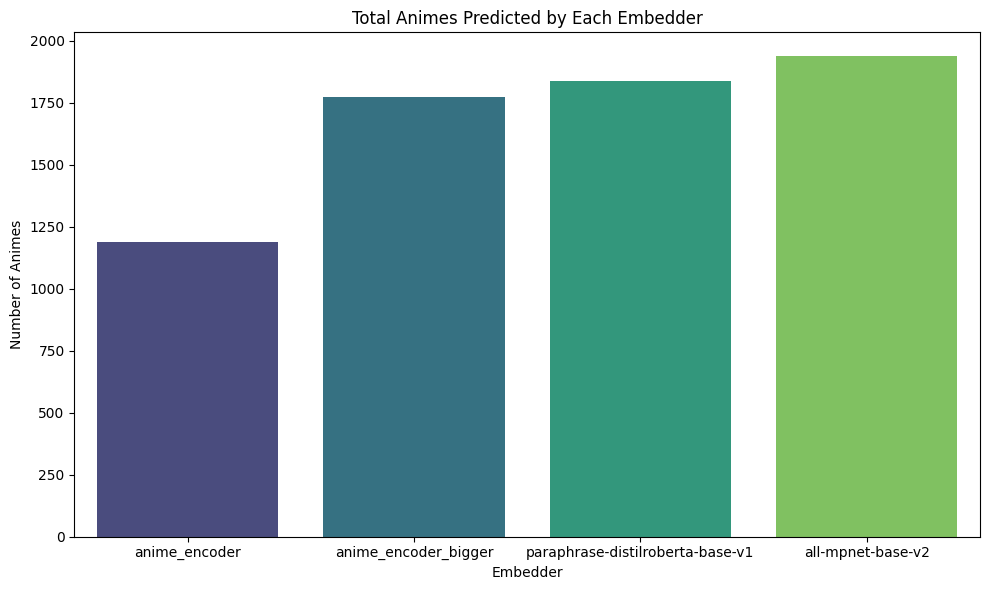

In [66]:
total_animes_predicted = {e: set() for e in embedders}
for user_id, recs in user_preds.items():
    for embedder, rec in recs.items():
        # total_animes_predicted[embedder].update((rec.keys()))
        total_animes_predicted[embedder].update(([r[0] for r in rec]))

embedder_counts = {k: len(v) for k, v in total_animes_predicted.items()}
sorted_embedder_counts = {k: v for k, v in sorted(embedder_counts.items(), key=lambda x: x[1])}

# Creating lists for plotting the sorted data
sorted_embedders = list(sorted_embedder_counts.keys())
sorted_counts = list(sorted_embedder_counts.values())

# Plotting the sorted data
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_embedders, y=sorted_counts, palette="viridis")
plt.title("Total Animes Predicted by Each Embedder")
plt.xlabel("Embedder")
plt.ylabel("Number of Animes")
plt.tight_layout()
plt.show()

In [67]:
rating_complete_test.head(2)

,user_id,anime_id,rating,nps_score
424120,2713,3731,10,1
316872,1965,552,10,1


In [68]:
# Initializing list for k_values and dictionary for counts of each embedder
k_values = []
embedder_counts = defaultdict(list)
raw_counts = []

def _avg_score(scores):
    int_score = int(round(sum(scores) / len(scores)))
    return score_map[int_score]

# Creating a range of integers from 1 to 10
_r = list(range(1, 11))

# Looping over the range to get the different k values (k-factor) for recommendations
for k_factor in tqdm(_r):
    # Looping over each user and their corresponding recommendations
    for user_id, user_recs in user_preds.items():
        # Looping over each embedder and the corresponding recommendations from the embedder
        for embedder, recs_from_embedder in user_recs.items():
            # Selecting the top-k recommendations for each user from each embedder
            # final_recs = sorted(recs_from_embedder, key=lambda x: x[1], reverse=True)[:k_factor]
            # print(final_recs)

            # Looping over the top-k recommendations
            for index, (recommended_anime_id, recommendation_score) in enumerate(recs_from_embedder):
                # Fetching the user rating for the recommended anime
                user_rating = user_anime_test_ratings.get(int(user_id), {}).get(int(recommended_anime_id))

                # print(f'User {user_id} has a rating of {user_rating} for anime {recommended_anime} from embedder {embedder}')

                # Checking if the user has a rating for the recommended anime
                if user_rating is not None:
                    avg_score = sum(recommendation_score) / len(recommendation_score)
                    raw_counts.append(
                        {
                            'nps_score': score_map[user_rating], 'index': index,
                            'user_id': user_id, 'anime_id': recommended_anime_id,
                            'embedder': embedder, 'rating': user_rating,
                            'count': len(recommendation_score), 'score': avg_score
                            }
                        )
                    # The score of each recommendation is adjusted by its rank and added to the embedder_counts dictionary
                    embedder_counts[embedder].append((_avg_score(recommendation_score) * (k_factor - index) / k_factor))

    # Calculating the average Net Promoter Score (NPS) for each embedder and adding it to the k_values list
    k_values.append({e: dict(k=k_factor, avg_nps=sum(l) / len(l), predictions_found_in_test_set=len(l)) for e, l in embedder_counts.items()})


  0%|          | 0/10 [00:00<?, ?it/s]

In [69]:
raw_counts[:2]

[{'nps_score': -1,
  'index': 7,
  'user_id': 1965,
  'anime_id': 896,
  'embedder': 'paraphrase-distilroberta-base-v1',
  'rating': 6,
  'count': 3,
  'score': 0.6646666526794434},
 {'nps_score': 1,
  'index': 1,
  'user_id': 1965,
  'anime_id': 904,
  'embedder': 'all-mpnet-base-v2',
  'rating': 9,
  'count': 4,
  'score': 0.7825000137090683}]

In [70]:
raw_counts_df = pd.DataFrame(raw_counts).drop_duplicates().reset_index()

# remove recs with only a single recommendation count to inspect the stronger signals
raw_counts_df = raw_counts_df[raw_counts_df['count'] > 1]

print(raw_counts_df.shape)
raw_counts_df.tail()

(3029, 9)


,level_0,nps_score,index,user_id,anime_id,embedder,rating,count,score
3206,3206,1,2,3464,11741,paraphrase-distilroberta-base-v1,10,2,0.610000
3207,3207,1,8,1131,13663,anime_encoder,10,3,0.788667
3208,3208,1,2,4341,5258,all-mpnet-base-v2,9,2,0.897000
3209,3209,1,2,4341,5258,anime_encoder_bigger,9,2,0.901000
3210,3210,1,0,5827,527,anime_encoder,10,2,0.764000
